## <center>Bangla Handwritten Math Solver<center> 

In [1]:
# calculate total execution time

from datetime import datetime
start_time = datetime.now()

print('Start Time: {}'.format(start_time))

Start Time: 2023-03-08 02:08:22.384411


## Importing Libraries

In [2]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours
from keras.models import load_model
# from rembg import remove
from PIL import Image

## Loading the Dataset 

In [3]:
x = []
y = []
datadir = 'dataset'
for folder in os.listdir(datadir):
    print(folder + '....')
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

0....
1....
2....
3....
4....
5....
6....
7....
8....
9....
add....
div....
mul....
sub....
9068
9068
labels : ['mul', '7', '4', '0', '6', '9', 'div', '2', '8', 'add', '3', '1', 'sub', '5']


### Time Update ###
End Time: 2023-03-08 02:08:29.363386
Duration: 0:00:06.978975


## Visualizing Images in the Dataset 

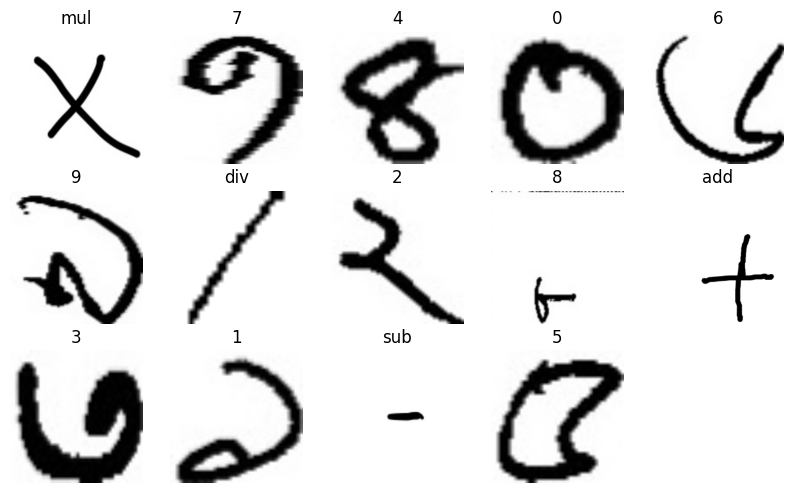

In [4]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

## Data Distribution of the Dataset 

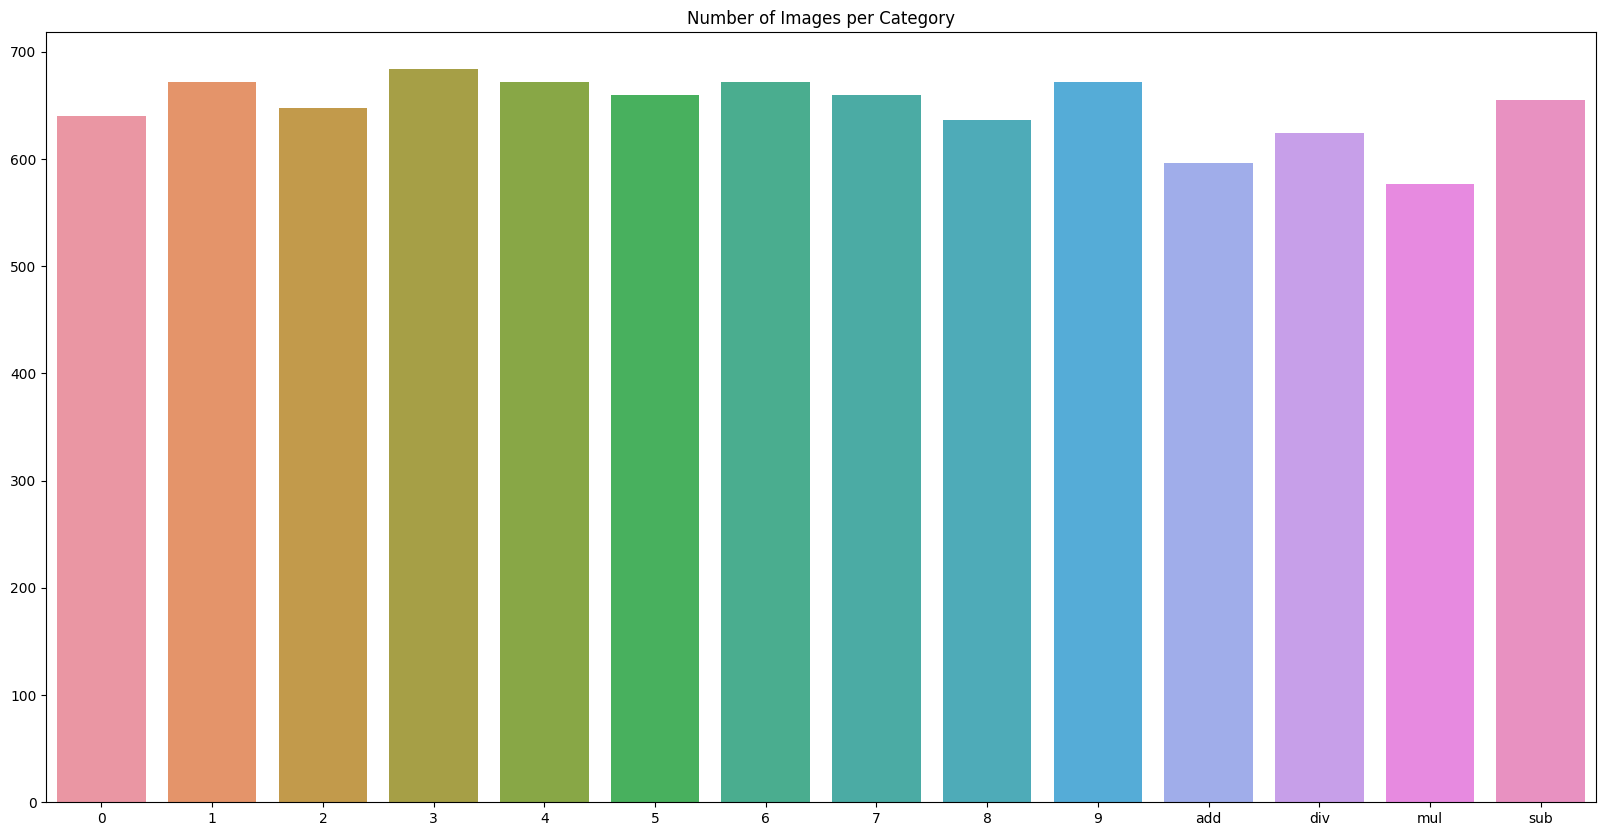

In [5]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique, y=count).set_title('Number of Images per Category')
plt.show()

In [6]:
# the dataset is not much imbalanced. So balancing is not required here much.

## Preprocessing the Data

In [7]:
X = []
for i in range(len(x)):
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

9068


In [8]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(y)
print(len(y))

9068


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

print(len(Y_train))
print(len(Y_test))

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

7254
1814
7254
1814


### Time Update ###
End Time: 2023-03-08 02:08:31.668146
Duration: 0:00:09.283735


## Data Distribution in Train

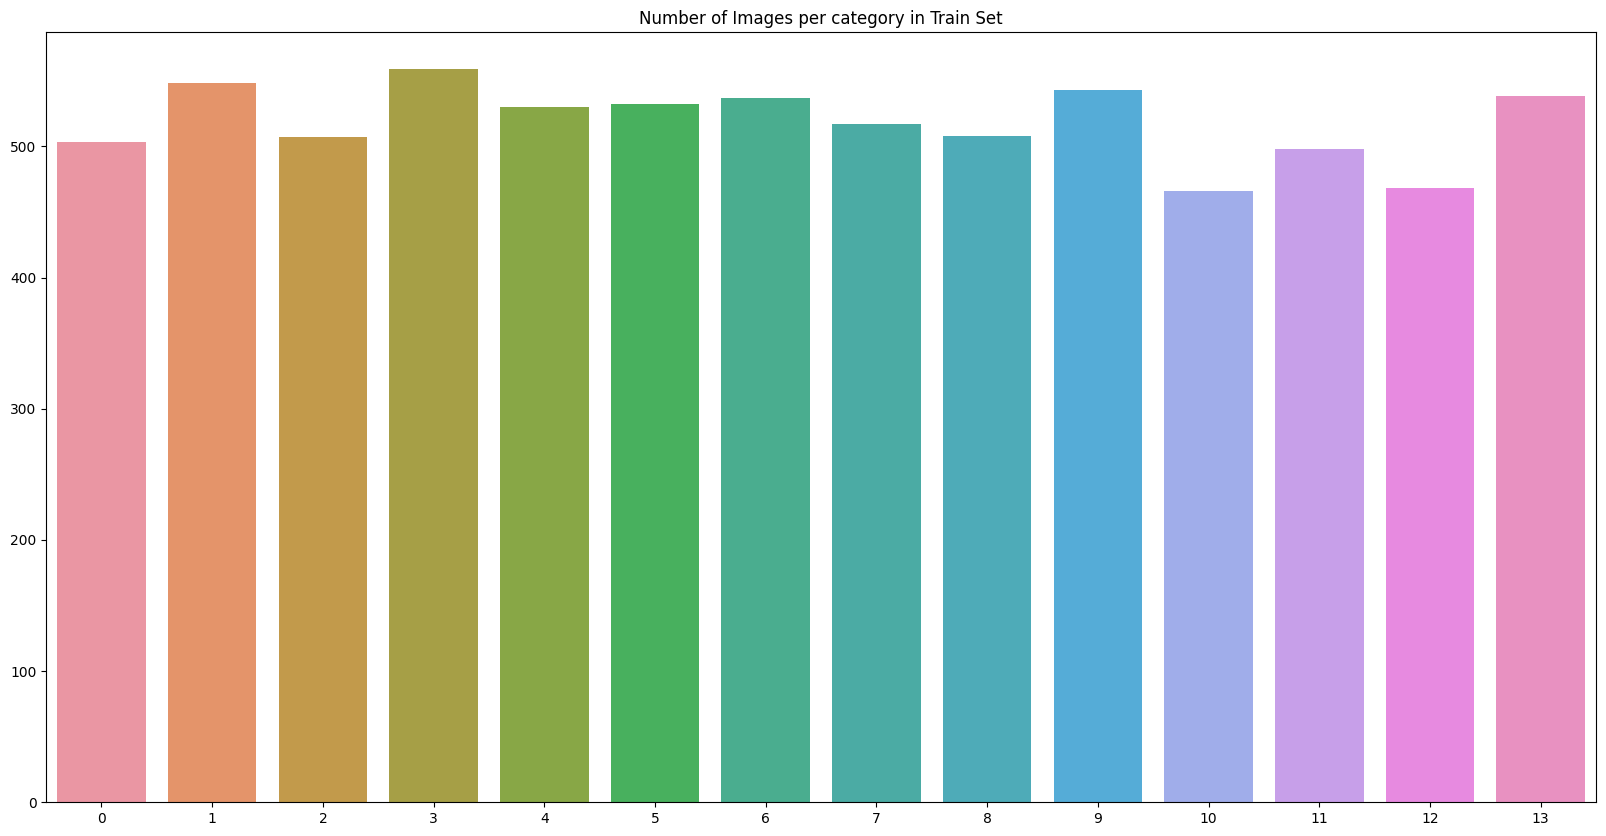

In [10]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_train, y=count_train).set_title('Number of Images per category in Train Set')
plt.show()

## Data Distribution in Test Set

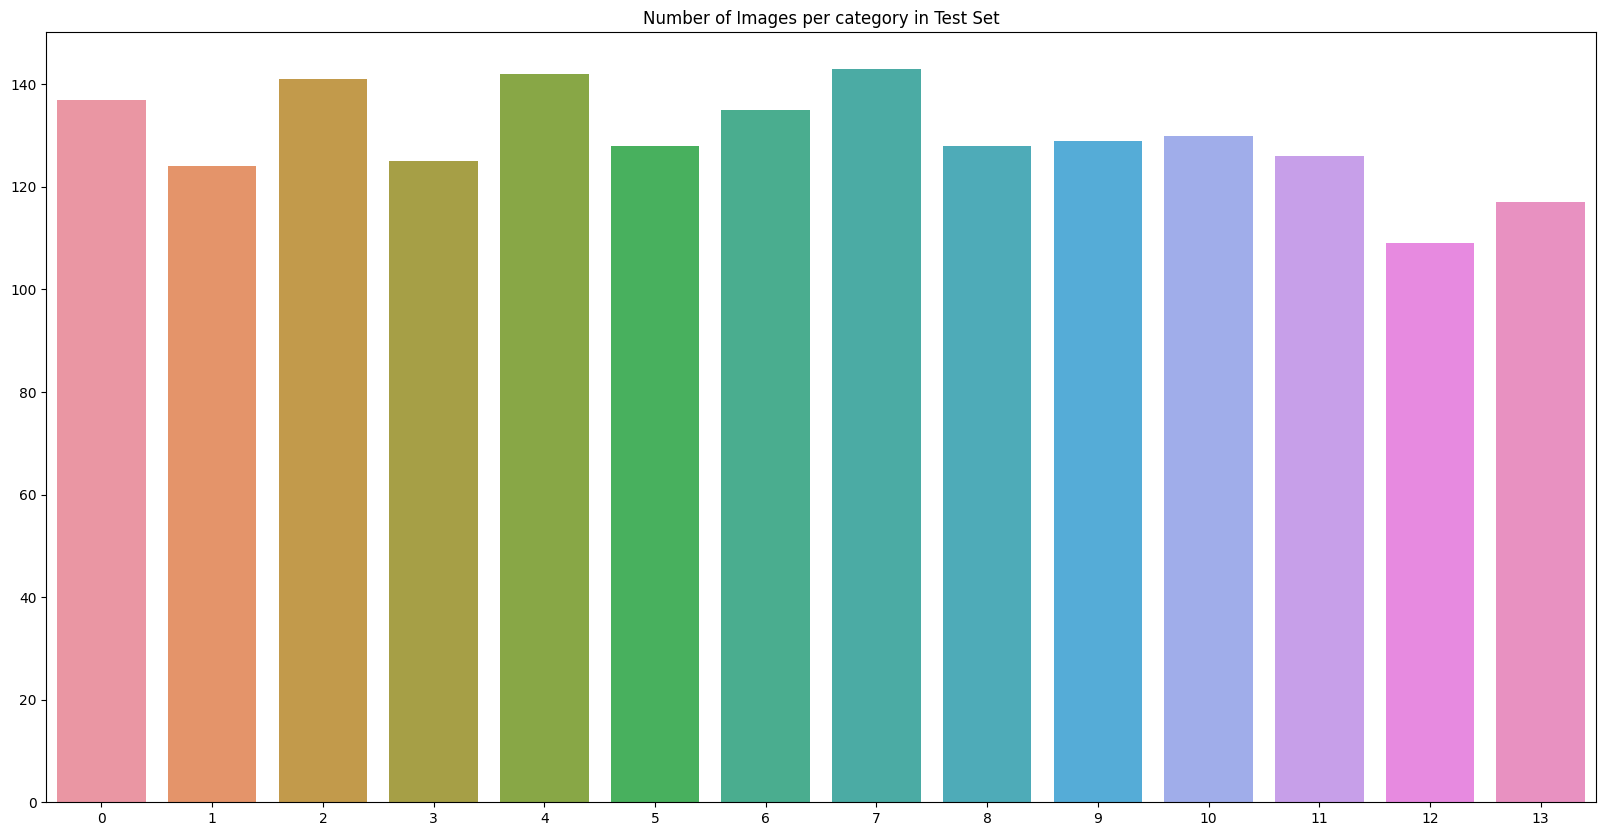

In [11]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_test, y=count_test).set_title('Number of Images per category in Test Set')
plt.show()

## Defining the Model 

In [12]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(7254, 32, 32, 1)
(1814, 32, 32, 1)
(7254, 14)
(1814, 14)


In [13]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [14]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

##  Training the Model

In [15]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('math_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]


########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))



### Time Update ###
End Time: 2023-03-08 02:08:33.688855
Duration: 0:00:11.304444


In [16]:
aug = ImageDataGenerator(zoom_range=0.1,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

Epoch 1/100
57/57 [==============================] - 14s 197ms/step - loss: 2.9960 - accuracy: 0.3981 - val_loss: 1.7580 - val_accuracy: 0.7481
Epoch 2/100
57/57 [==============================] - 9s 157ms/step - loss: 1.2039 - accuracy: 0.7801 - val_loss: 1.0802 - val_accuracy: 0.8352
Epoch 3/100
57/57 [==============================] - 11s 195ms/step - loss: 0.8088 - accuracy: 0.8451 - val_loss: 0.8490 - val_accuracy: 0.8666
Epoch 4/100
57/57 [==============================] - 9s 156ms/step - loss: 0.6542 - accuracy: 0.8666 - val_loss: 0.7071 - val_accuracy: 0.8848
Epoch 5/100
57/57 [==============================] - 9s 156ms/step - loss: 0.5669 - accuracy: 0.8872 - val_loss: 0.6137 - val_accuracy: 0.8997
Epoch 6/100
57/57 [==============================] - 8s 145ms/step - loss: 0.5212 - accuracy: 0.8936 - val_loss: 0.5798 - val_accuracy: 0.9041
Epoch 7/100
57/57 [==============================] - 8s 145ms/step - loss: 0.4608 - accuracy: 0.9060 - val_loss: 0.5736 - val_accuracy: 0.89

Epoch 58/100
57/57 [==============================] - 8s 148ms/step - loss: 0.1229 - accuracy: 0.9753 - val_loss: 0.2259 - val_accuracy: 0.9432
Epoch 59/100
57/57 [==============================] - 9s 152ms/step - loss: 0.1328 - accuracy: 0.9712 - val_loss: 0.1830 - val_accuracy: 0.9614
Epoch 60/100
57/57 [==============================] - 8s 148ms/step - loss: 0.1167 - accuracy: 0.9766 - val_loss: 0.1666 - val_accuracy: 0.9664
Epoch 61/100
57/57 [==============================] - 8s 145ms/step - loss: 0.1230 - accuracy: 0.9733 - val_loss: 0.2100 - val_accuracy: 0.9559
Epoch 62/100
57/57 [==============================] - 8s 148ms/step - loss: 0.1139 - accuracy: 0.9763 - val_loss: 0.2154 - val_accuracy: 0.9432
Epoch 63/100
57/57 [==============================] - 9s 153ms/step - loss: 0.1182 - accuracy: 0.9753 - val_loss: 0.1761 - val_accuracy: 0.9620
Epoch 64/100
57/57 [==============================] - 8s 142ms/step - loss: 0.1118 - accuracy: 0.9784 - val_loss: 0.2117 - val_accuracy:

##  Loss and Accuracy Plot

In [17]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

## Confusion Matrix 

In [18]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)

matrix = confusion_matrix(Y_test_hat, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
figure = plt.figure(figsize=(20, 10))
sb.heatmap(df_cm, annot=True, fmt='d')

## Classification Report

In [19]:
print(classification_report(Y_test_hat, ypred))

## Saving the Model 

In [20]:
model.save('math_symbol_and_digit_recognition.h5')

## Total Execution Time

In [21]:
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))